## Importing Packages ##

In [9]:
import os
import sys
import subprocess
import tempfile
import random
import glob
from itertools import compress
import os.path as op
import numpy as np
import skimage.io as sio
import pandas as pd
import importlib
import math
from math import sqrt
import matplotlib.pyplot as plt
from os import listdir, getcwd, chdir
from os.path import isfile, join
from sklearn import linear_model
from sklearn import svm

import diff_classifier
import diff_classifier.utils as ut
import diff_classifier.msd as msd
import diff_classifier.features as ft
import diff_classifier.heatmaps as hm
import diff_classifier.aws as aws

## Defining filename and importing video

In [10]:
tiffname = '1micrometerRedPNPsConfocal500x500_cropArea40x_20s.tif'
os.chdir('/Users/claudialozano/Dropbox/PycharmProjects/AD_nanoparticle/diff_classifier/notebooks/development/MPT_Data/{}/'.format(tiffname.replace('.tif', '')))

In [11]:
ovideo = sio.imread(tiffname) # Read tif file 
oshape = ovideo.shape         # Shape of Original Video 
dshape = (125,125) #desired shape of smaller videos 
oshape
#oshape from Nance Lab is (651, 2044, 2048)

(170, 500, 500)

## Splitting original video into smaller videos sized

In [12]:


nvideo = np.zeros(oshape, dtype=ovideo.dtype) # Create an empty array with original's video shape
nvideo[0:oshape[0], 0:oshape[1], :] = ovideo 

new_image = np.zeros((oshape[0], dshape[0], dshape[1]), dtype=ovideo.dtype) # Create new empty array with desired shape dimensions
names = []


division_rows = int(oshape[1]/dshape[0]) # Determine the number of row we want to the divide the new video into 
division_cols = int(oshape[2]/dshape[1]) # Determine the number of columns we want to the divide the new video into 
for row in range(division_rows):
    for col in range(division_cols):
        new_image = nvideo[:, row*dshape[0]:(row+1)*dshape[0], col*dshape[1]:(col+1)*dshape[1]]
        current = tiffname.split('.tif')[0] + '_%s_%s.tif' % (row, col)
        sio.imsave(current, new_image)
        names.append(current)

/var/folders/36/qf3_gzks28b8dbjdqt8d5tf40000gp/T/ipykernel_16967/3195732950.py:14: UserWarning: 1micrometerRedPNPsConfocal500x500_cropArea40x_20s_0_0.tif is a low contrast image
  sio.imsave(current, new_image)
/var/folders/36/qf3_gzks28b8dbjdqt8d5tf40000gp/T/ipykernel_16967/3195732950.py:14: UserWarning: 1micrometerRedPNPsConfocal500x500_cropArea40x_20s_0_1.tif is a low contrast image
  sio.imsave(current, new_image)
/var/folders/36/qf3_gzks28b8dbjdqt8d5tf40000gp/T/ipykernel_16967/3195732950.py:14: UserWarning: 1micrometerRedPNPsConfocal500x500_cropArea40x_20s_0_2.tif is a low contrast image
  sio.imsave(current, new_image)
/var/folders/36/qf3_gzks28b8dbjdqt8d5tf40000gp/T/ipykernel_16967/3195732950.py:14: UserWarning: 1micrometerRedPNPsConfocal500x500_cropArea40x_20s_0_3.tif is a low contrast image
  sio.imsave(current, new_image)
/var/folders/36/qf3_gzks28b8dbjdqt8d5tf40000gp/T/ipykernel_16967/3195732950.py:14: UserWarning: 1micrometerRedPNPsConfocal500x500_cropArea40x_20s_1_0.tif is

## For now, tracking is done manually using the plugin TrackMate in ImageJ. 

In [13]:
files = glob.glob('Traj*.csv') # get rename the trajectory .csv files 
files

['Traj_1_0_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_3_0_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_1_2_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_3_2_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_0_1_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_2_1_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_0_3_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_2_3_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_0_0_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_2_0_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_0_2_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_2_2_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_1_1_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_3_1_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv',
 'Traj_1_3_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.c

## Defining list of all small videos to be quantified (calculating msds and features) ##

In [14]:
filename = tiffname.replace('.tif', '')
vid_time = 20 # length of the video in seconds 
fps = oshape[0]/vid_time
names = []
for i in range(0, division_rows):
    for j in range(0,division_cols):
        names.append('{}_{}_{}.tif'.format(filename, i, j))
        

## Calculating MSDs and features for the videos that have been tracked. This uses the Traj .csv files and generates an msd and features .csv file for the videos being quantified. It uses the multiple small vid Traj .csv files to generate a single msd and features .csv file. Essentially, this runs the kn.assemble_msds() function ##

In [15]:
xft_file = 'features_{}.csv'.format(filename)
msd_file = 'msd_{}.csv'.format(filename)

In [16]:
"""Creating MSD File"""
counter = 0
merged = False
for name in names:
    try:
        ##### Get the numbering of the sectioned videos ####
        row = int(name.split(filename)[1].split('.')[0].split('_')[1])
        col = int(name.split(filename)[1].split('.')[0].split('_')[2])
        
        traj_file = "Traj_{}_{}_{}.csv".format(row, col, filename)
        local_name = traj_file

        to_add = pd.read_csv(local_name) # Gets all the values from the tajectory file 
        
        # Mine have an extra 3 rows of non important information so we get rid of the first three rows 
        to_add = to_add.iloc[3:]  
        
        ##### Deleting unecessary columns in the CSV file that ImageJ(FIJI) outputs #####
        del to_add['LABEL']
        del to_add['POSITION_Z']
        del to_add['POSITION_T']
        del to_add['RADIUS']
        del to_add['VISIBILITY']
        del to_add['MANUAL_SPOT_COLOR']
        del to_add['MEDIAN_INTENSITY_CH1']
        del to_add['MIN_INTENSITY_CH1']
        del to_add['MAX_INTENSITY_CH1']
        del to_add['TOTAL_INTENSITY_CH1']
        del to_add['STD_INTENSITY_CH1']
        del to_add['CONTRAST_CH1']
        
        del to_add['ID'] # Not really used by msds2 file so I also delete it 
        
        # This column is not present in our CSV file 
        # del to_add['ESTIMATED_DIAMETER']
       
        # Get the names and format in the one taken by the MSDS2 function
        to_add = to_add.rename(columns={'TRACK_ID':'Track_ID','QUALITY':'Quality','FRAME':'Frame',
                                        'POSITION_X':'X','POSITION_Y':'Y', 
                                        'MEAN_INTENSITY_CH1':'Mean_Intensity', 'SNR_CH1':'SN_Ratio'})
        
        to_add.sort_values(['Track_ID', 'Frame'], ascending=[1,1])
        to_add = to_add.astype('float64')  # Declaring the values to have decimal points 

        counter = 0 
        partids = to_add.Track_ID.unique() # Getting all the unique TRACK_IDs: Unique particles 
        for partid in partids:
            to_add.loc[to_add.Track_ID == partid, 'Track_ID'] = counter
            counter = counter +1

        # Taking into account that we are in a different row and column of the original video 
        # Since we devided the videos the X and Y postions are offset and this takes care of that 
        
        to_add['X'] = to_add['X'] + dshape[0]*col 
        to_add['Y'] = dshape[1] - to_add['Y'] + dshape[1]*(division_rows-1-row)
        
        length = int(max(to_add['Frame']) + 1)
        
        # Cheking if it is the first video, if so we need to create merge array
        if type(merged) == bool: 
            merged = msd.all_msds2(to_add, frames=length)
            
        # If merged has already been created we can concatenate the next array
        else:    
            # Since each particle is different of the different videos we need to take that into account. 
            # eg Particle with Track ID 1 from video 1_1 is not the same as Particle with Track ID 1 from 
            # video 1_2, so we shift the Track IDs
            to_add['Track_ID'] = to_add['Track_ID'] + max(merged['Track_ID']) +1 
            msds2 = msd.all_msds2(to_add, frames=length)
            merged = pd.concat([merged,msds2])
    
        counter = counter +1   
        print('Done calculating MSDs for row {} and col {}'.format(row, col))
        
    except pd.errors.EmptyDataError:
 
        print('Found empty file : {}'.format(name))


merged.to_csv(msd_file) # Create CSV file from the array containing the MSDs

HERE
       Frame  Track_ID          X           Y        MSDs     Gauss  \
0        0.0       0.0  35.007963  456.000093    0.000000  0.000000   
1        1.0       0.0  31.963769  457.002221   24.554095  0.769379   
2        2.0       0.0  33.984751  459.501098   58.608458  0.488315   
3        3.0       0.0  36.005733  461.999976  101.535665  0.455896   
4        4.0       0.0  32.992323  454.998788  153.712793  0.444511   
...      ...       ...        ...         ...         ...       ...   
11487  164.0      67.0  73.462851  436.251939         NaN       NaN   
11488  165.0      67.0  76.939559  438.001959         NaN       NaN   
11489  166.0      67.0  66.054502  430.000843         NaN       NaN   
11490  167.0      67.0        NaN         NaN         NaN       NaN   
11491  168.0      67.0        NaN         NaN         NaN       NaN   

          Quality  SN_Ratio  Mean_Intensity  
0      991.408081  0.224968      649.619048  
1      342.896057  0.248306      291.142857  
2   

       Frame  Track_ID           X           Y        MSDs     Gauss  \
0        0.0     402.0  277.991075  344.000397    0.000000  0.000000   
1        1.0     402.0  280.233066  340.004038   18.540450  0.902484   
2        2.0     402.0  284.820057  342.668860   45.149042  0.747893   
3        3.0     402.0  289.407047  345.333681   78.015711  0.779185   
4        4.0     402.0  293.994037  347.998503  110.530383  0.867629   
...      ...       ...         ...         ...         ...       ...   
13255  165.0     479.0  321.009971  314.997542         NaN       NaN   
13256  166.0     479.0  323.992583  311.994732         NaN       NaN   
13257  167.0     479.0         NaN         NaN         NaN       NaN   
13258  168.0     479.0         NaN         NaN         NaN       NaN   
13259  169.0     479.0         NaN         NaN         NaN       NaN   

          Quality  SN_Ratio  Mean_Intensity  
0      426.897034  0.224078      325.571429  
1      407.039856  0.307953      390.904762

HERE
       Frame  Track_ID          X          Y        MSDs     Gauss  \
0        0.0     852.0  52.009393  73.000721    0.000000  0.000000   
1        1.0     852.0  44.993629  67.999832   37.866075  1.181812   
2        2.0     852.0  39.829629  58.998896   75.011954  0.948777   
3        3.0     852.0  43.991986  50.001482  111.641099  0.941669   
4        4.0     852.0  40.879030  64.999014  145.989091  0.916477   
...      ...       ...        ...        ...         ...       ...   
13425  165.0     930.0  27.992098  57.998001         NaN       NaN   
13426  166.0     930.0  34.426544  48.001705         NaN       NaN   
13427  167.0     930.0  32.993436  40.000154         NaN       NaN   
13428  168.0     930.0        NaN        NaN         NaN       NaN   
13429  169.0     930.0        NaN        NaN         NaN       NaN   

           Quality  SN_Ratio  Mean_Intensity  
0      1226.112915  0.223303      783.952381  
1       584.513672  0.221413      414.904762  
2       322.4

In [17]:
# Calculate the feature file 
merged_ft = ft.calculate_features(merged)
merged_ft.to_csv(ft_file)

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

NameError: name 'ft_file' is not defined

## Plot the Trajectories and Mean Square Distance

In [ ]:
merged['X']

features_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv
msd_1micrometerRedPNPsConfocal500x500_cropArea40x_20s.csv
Plotted 1micrometerRedPNPsConfocal500x500_cropArea40x_20s trajectories successfully.
Successfully generated trajectory plot for 1micrometerRedPNPsConfocal500x500_cropArea40x_20s


ValueError: cannot reshape array of size 193844 into shape (1142,170)

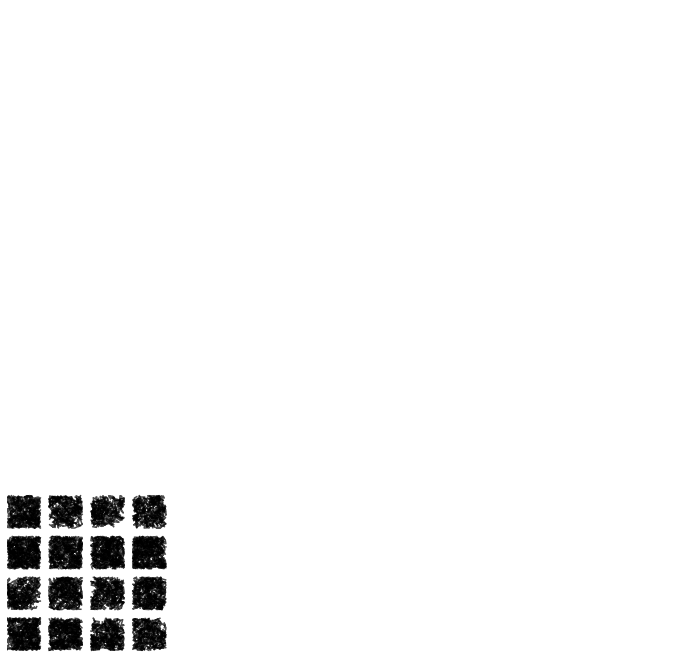

<Figure size 720x720 with 0 Axes>

In [18]:
msds = 'msd_{}.csv'.format(filename)
feat = 'features_{}.csv'.format(filename)
print(feat)
print(msds)
hm.plot_trajectories(filename, resolution=oshape[1], rows=division_rows, cols=division_cols, upload=False, figsize=(12, 12), bucket = 'mckenna.data')
print('Successfully generated trajectory plot for {}'.format(filename))
geomean, geoSEM = hm.plot_individual_msds(filename, x_range=2, y_range=10, umppx=0.33, fps=fps, upload=False, bucket='mckenna.data')
print('Successfully generated csv files for {}'.format(filename))

# Plot Feature Heatmap

In [ ]:
org_feat = 'orig_features_{}.csv'.format(filename)
hm.plot_heatmap(org_feat, resolution=512, rows=division_rows, cols=division_cols, upload=False, figsize=(12, 12), bucket = 'mckenna.data')

feat = 'features_{}.csv'.format(filename)
hm.plot_heatmap(feat, resolution=512, rows=division_rows, cols=division_cols, upload=False, figsize=(12, 12), bucket = 'mckenna.data')